In [16]:
%matplotlib notebook

import glob
import argparse
import numpy              as np
import matplotlib.pyplot as plt

from scipy.interpolate    import interp1d
from scipy.interpolate    import interp2d
from scipy                import integrate

# detectors' pixel size
HST_WFC3CAM_pixel_size = 0.13   # arcsec per pixel
JWST_NIRCAM_pixel_size = 0.032  # arcsec per pixel

# Constants
cm_in_pc = 3.0857e18
sun_luminosity = 3.828e33
arcsec_in_rad = 206265

# Cosmo params
Omega_lam = 0.7274
Omega_M_0 = 0.2726
Omega_k = 0.0
h = 0.704

# Functions to compute Angular diameter distance D_A [Mpc]
E   = lambda x: 1/np.sqrt(Omega_M_0*np.power(1+x,3)+Omega_lam+Omega_k*np.power(1+x,2))
D_m = lambda x: D_c(x)
D_c = lambda x: (9.26e27/h)*integrate.quad(E, 0, x)[0]
D_A = lambda x: D_m(x)/(1+x)/cm_in_pc/1e6  # Angular distance [Mpc]



<IPython.core.display.Javascript object>


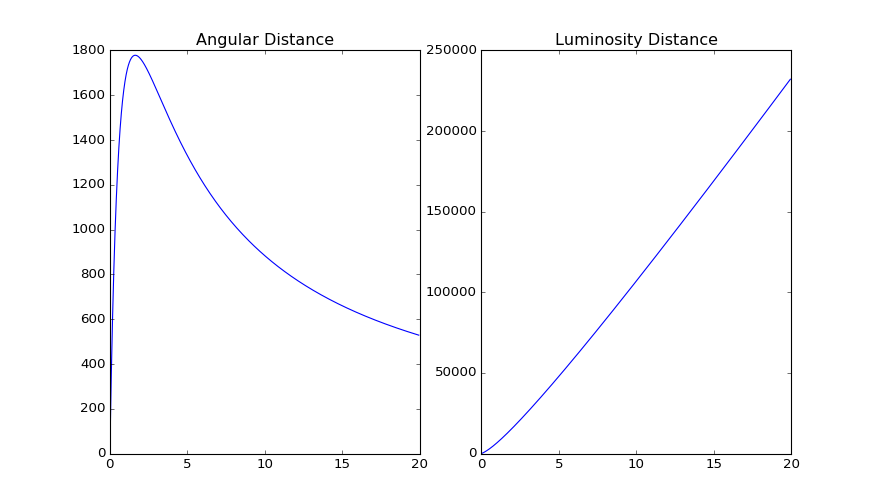

In [18]:
z = np.logspace(-2,1.3,1000)
values = np.zeros_like(z)
for i in range(len(z)): values[i] = D_A(z[i])

plt.figure(1)
plt.subplot(1,2,1)
plt.title('Angular Distance')
plt.plot(z,values)

plt.subplot(1,2,2)
plt.title('Luminosity Distance')
plt.plot(z,values*(1+z)*(1+z))


<IPython.core.display.Javascript object>


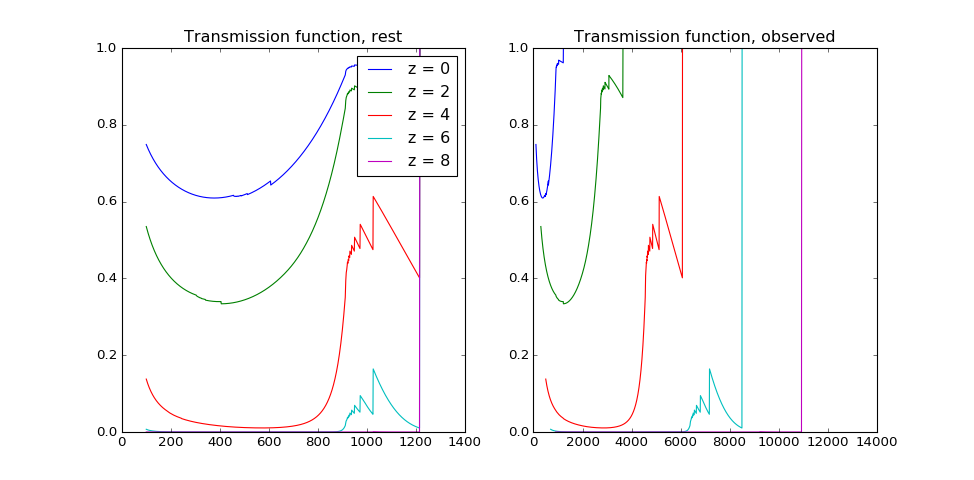

In [27]:
'''
Interstellar medium transmission function
'''

global F_ISM

table = np.loadtxt('data/table_transmition_ISM.dat')
lam_rest   = table[1:,0]
z          = table[0,1:]
trans_coef = table[1:,1:]
F_ISM = interp2d(z, lam_rest, trans_coef)

plt.figure(2)
plt.subplot(1,2,1)
plt.title('Transmission function, rest')
for i in range(0,10,2):
    plt.plot(lam_rest,F_ISM(i,lam_rest),label='z = ' + str(i))
plt.legend(loc='upper right')
plt.subplot(1,2,2)
plt.title('Transmission function, observed')
for i in range(0,10,2):
    plt.plot(lam_rest*(i+1),F_ISM(i,lam_rest),label='z = ' + str(i))

In [29]:
def init_lum_tables():

    '''
    Luminosity tables as a function of metallicity Z and stars' birth time t
    '''

    global lam_list, lookup, Z, logt

    muf_list = sorted(glob.glob("data/drt/muv.bin*"))
    lam_list = np.zeros(len(muf_list))
    lookup = np.zeros([len(muf_list), 188, 22])

    for i in range(len(muf_list)):
        f           = open(muf_list[i])
        header      = f.readline()
        lam_list[i] = float(header.split()[2])

        f.close()

        data = np.genfromtxt(muf_list[i], skip_header=1)
        lookup[i, :, :] = data[1:,1:]

    Z = data[0, 1:]  # metallicity [Sun_Z]
    logt = data[1:, 0]  # log10(t) [yr]
    
init_lum_tables()
print(lam_list)

[  905.   915.   925.   935.   945.   955.   965.   975.   985.   995.
  1005.  1015.  1025.  1035.  1045.  1055.  1065.  1075.  1085.  1095.
  1105.  1115.  1125.  1135.  1145.  1155.  1165.  1175.  1185.  1195.
  1205.  1215.  1225.  1235.  1245.  1255.  1265.  1275.  1285.  1295.
  1305.  1315.  1325.  1335.  1345.  1355.  1365.  1375.  1385.  1395.
  1405.  1415.  1425.  1435.  1442.  1447.  1455.  1465.  1475.  1485.
  1495.  1505.  1512.  1517.  1525.  1535.  1545.  1555.  1565.  1575.
  1585.  1595.  1605.  1615.  1625.  1635.  1645.  1655.  1665.  1672.
  1677.  1685.  1695.  1705.  1715.  1725.  1735.  1745.  1755.  1765.
  1775.  1785.  1795.  1805.  1815.  1825.  1835.  1845.  1855.  1865.
  1875.  1885.  1895.  1905.  1915.  1925.  1935.  1945.  1955.  1967.
  1976.  1984.  1995.  2005.  2015.  2025.  2035.  2045.  2055.  2065.
  2074.  2078.  2085.  2095.  2105.  2115.  2125.  2135.  2145.  2155.
  2165.  2175.  2185.  2195.  2205.  2215.  2225.  2235.  2245.  2255.
  2265

In [30]:
def filter_bandwidth(a,b,x):

    position_in_lam_array = []

    for i in range(0,len(x)):
        if (a<=x[i] and x[i]<=b):
            if(F_filter(x[i])>=0.5e-3):
                position_in_lam_array.append(i)

    return position_in_lam_array

[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]


<IPython.core.display.Javascript object>


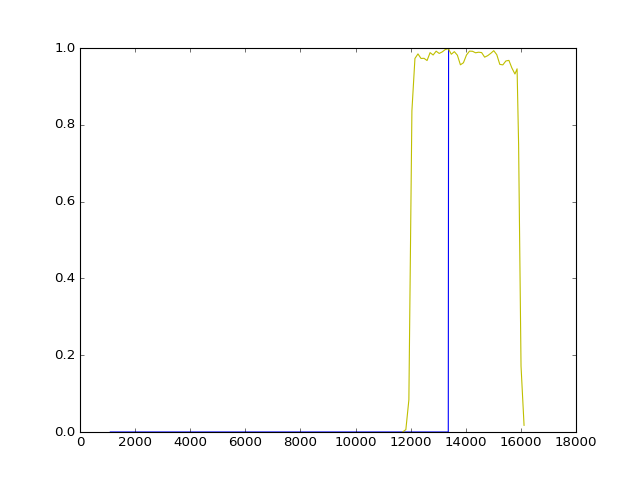

In [39]:
cam_filter = 'f140w'

def HST_filter_init(z):

    '''
    Hubble Space Telescope filter initialization function
    '''

    global F_filter

    filter_b = np.loadtxt('data/filter_' + cam_filter + '.dat')
    F_filter = interp1d(filter_b[:,0], filter_b[:,1],fill_value=0.0,bounds_error=False)
    a,b = np.min(filter_b[:,0]),np.max(filter_b[:,0])
    lamb_positions = filter_bandwidth(a,b,lam_list*(1+z))

    return lamb_positions

redshift = 10
a = HST_filter_init(redshift)
print(a)
plt.figure(3)
plt.plot(lam_rest*(redshift+1),F_ISM(redshift,lam_rest),label='z = ' + str(i))
plt.plot(lam_list[a]*(redshift+1),F_filter(lam_list[a]*(redshift+1)),'y-')

[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]


<IPython.core.display.Javascript object>


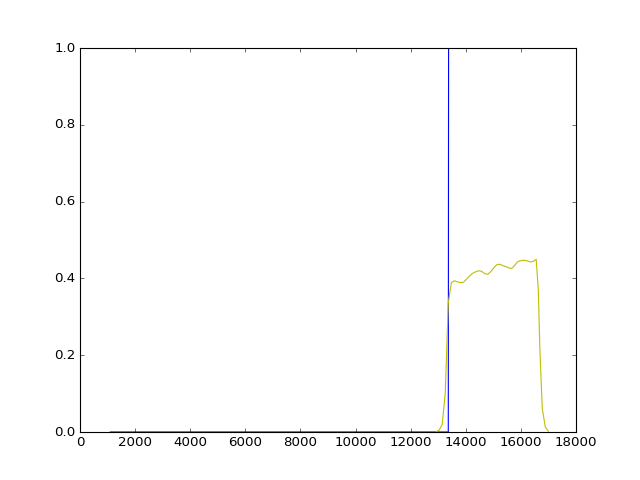

In [40]:
cam_filter = 'F150W'

def JWST_filter_init(z):

    '''
    James Webb Space Telescope filter initialization function
    '''

    global F_filter

    wavelengths,transmission = np.loadtxt('data/filter_' + cam_filter + '.dat',skiprows=1).T
    wavelengths *= 1e4
    F_filter = interp1d(wavelengths, transmission,fill_value=0.0,bounds_error=False)
    a,b = np.min(wavelengths),np.max(wavelengths)
    lamb_positions = filter_bandwidth(a,b,lam_list*(1+z))

    return lamb_positions

redshift = 10
a = JWST_filter_init(redshift)
print(a)
plt.figure(4)
plt.plot(lam_rest*(redshift+1),F_ISM(redshift,lam_rest),label='z = ' + str(i))
plt.plot(lam_list[a]*(redshift+1),F_filter(lam_list[a]*(redshift+1)),'y-')


In [41]:
input_radius = 30 # kpc
redshift = 10
theta_arcsec = (2 * input_radius * 1e3) / (D_A(redshift) * 1e6) * arcsec_in_rad

nbins_HST = int(theta_arcsec / HST_WFC3CAM_pixel_size)
nbins_JWST = int(theta_arcsec / JWST_NIRCAM_pixel_size)

print(theta_arcsec)
print(nbins_HST)
print(nbins_JWST)

14.000829996904764
107
437


In [42]:
input_radius = 30 # kpc
redshift = 4
theta_arcsec = (2 * input_radius * 1e3) / (D_A(redshift) * 1e6) * arcsec_in_rad

nbins_HST = int(theta_arcsec / HST_WFC3CAM_pixel_size)
nbins_JWST = int(theta_arcsec / JWST_NIRCAM_pixel_size)

print(theta_arcsec)
print(nbins_HST)
print(nbins_JWST)

8.413769338060453
64
262
